# Homework Assignment 3

Using the [Seattle Library Collection Inventory Dataset](https://www.kaggle.com/city-of-seattle/seattle-library-collection-inventory#library-collection-inventory.csv) and Vaex please, answer the following questions:

Important Note: **You can use a reltaviely small subset of the big dataset.**

In [1]:
!pip install vaex "kagglehub[pandas-datasets]" openpyxl seaborn plotly

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import kagglehub
import vaex
import os

In [6]:

os.environ['KAGGLEHUB_CACHE'] = '/Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות'
path = kagglehub.dataset_download("city-of-seattle/seattle-library-collection-inventory", )
print("Path to dataset files:", path)

100%|██████████| 3.77G/3.77G [05:10<00:00, 13.0MB/s]

Extracting files...


Path to dataset files: /Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות/datasets/city-of-seattle/seattle-library-collection-inventory/versions/7


In [ ]:
seattle_df = next(vaex.from_csv(f"/Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות/datasets/city-of-seattle/seattle-library-collection-inventory/versions/7/library-collection-inventory.csv", chunk_size=2_000_000))
seattle_df = seattle_df.dropna()
seattle_df.head()

#,BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,FloatingItem,ItemLocation,ReportDate,ItemCount
0,3011076,"""A tale of two friends / adapted by Ellie O'Ryan...","O'Ryan, Ellie","'1481425730, 1481425749, 9781481425735, 97814814...",2014.,"Simon Spotlight,","'Musicians Fiction, Bullfighters Fiction, Best f...",jcbk,ncrdr,Floating,qna,2017-09-01T00:00:00.000,1
1,2765249,Lone wolf [text (large print)] / Jodi Picoult.,"Picoult, Jodi, 1966-","1611733669, 9781611733662",2012.,"Center Point Publishing,","'Accident victims Fiction, Terminal care Decisio...",acbk,nalpfic,Floating,swt,2017-09-01T00:00:00.000,1
2,3174946,Pete the Cat. Snow daze / by James Dean.,"Dean, James, 1957-","'0062404253, 0062404261, 9780062404251, 97800624...",[2016],"Harper, an imprint of HarperCollinsPublishers,",'Pete the Cat Fictitious character Juvenile fict...,jcbk,ncrdr,Floating,bal,2017-09-01T00:00:00.000,3
3,2737405,'How to help the Earth / by the Lorax with Tish ...,"Rabe, Tish","'0375869778, 0375969772, 9780375869778, 97803759...",c2012.,"Random House,","'Refuse and refuse disposal Juvenile literature,...",jcbk,ncrdr,Floating,gwd,2017-09-01T00:00:00.000,1
4,2833067,"""Miss Peregrine's Home for Peculiar Children / R...","Riggs, Ransom","1410450236, 9781410450234",2012.,"Thorndike Press,","'Grandfathers Juvenile fiction, Orphanages Juven...",acbk,nylp,Floating,bea,2017-09-01T00:00:00.000,1
5,3056858,Strangers / Bill Pronzini.,"Pronzini, Bill","1410470857, 9781410470850",2014.,"Thorndike Press, a part of Gale, Cengage Learning,","'Teenage boys Fiction, Rape Investigation Fictio...",acbk,nalpfic,Floating,hip,2017-09-01T00:00:00.000,1
6,3077219,Rebel power! / written by Lauren Nesworthy.,"Nesworthy, Lauren.","'1465435956, 1465435964, 9781465435958, 97814654...",2015.,"DK Publishing,",'Star Wars rebels Television program Juvenile li...,jcbk,ncrdr,Floating,rbe,2017-09-01T00:00:00.000,1
7,2840736,'Domestic malice : a novel / by Jessica Fletcher...,"Bain, Donald, 1935-","0451238036, 9780451238030",2012.,"Obsidian,","'Fletcher Jessica Fiction, Women novelists Ficti...",acbk,namys,Floating,dth,2017-09-01T00:00:00.000,1
8,3236201,'Prussian blue : a Bernie Gunther novel / Philip...,"Kerr, Philip","1524756156, 9781524756154",[2017],"Random House Large Print,","'Gunther Bernhard Fictitious character Fiction, ...",acbk,nalpfic,Floating,dlr,2017-09-01T00:00:00.000,1
9,2991835,'A fighting chance [sound recording]/ Elizabeth ...,"Warren, Elizabeth","1427239169, 9781427239167",p2014.,Macmillan Audio,"'Warren Elizabeth, Women legislators United Stat...",accd,nacdnf,Floating,glk,2017-09-01T00:00:00.000,1


<!-- **Question 1:** Using Vaex, write a function that returns the most popular book in each subject. Use it to find the most popular book in
    the _Mystery Fiction_ subject (15pt) -->

In [ ]:
def vaex_explode(df: vaex.DataFrame, col: str) -> vaex.DataFrame:
    p_df =  df.to_pandas_df().explode([col])
    v_df = vaex.from_pandas(p_df)
    return v_df

def sepeate_subjects_to_subject(df: vaex.DataFrame)-> vaex.DataFrame:
    df["Subjects"] = df["Subjects"].str.strip()
    df["Subjects"] = df["Subjects"].str.lower()
    df["Subjects"] = df["Subjects"].str.split(",")
    df = vaex_explode(df, "Subjects")

    df.rename('Subjects', 'Subject')

    df['Subject'] = df["Subject"].apply(lambda y: y.strip().lower())
    return df

def get_most_popular_book_by_subject(df: vaex.DataFrame):

    df = sepeate_subjects_to_subject(df)

    df_grouped = df.groupby(["Subject", "Title"]).agg(
        {"ItemCount":"sum"}).sort(by="ItemCount", ascending=False)

    all_subjects = df_grouped["Subject"].unique()
    most_popular_book_per_subject={}

    for subject in all_subjects:
        most_popular_book_per_subject[subject]=0

    for subject in all_subjects:
      all_books_in_subject=df_grouped[df_grouped["Subject"]==subject]
      most_popular_book_in_subject=all_books_in_subject[0]
      most_popular_book_per_subject[subject]=most_popular_book_in_subject[1]

    return most_popular_book_per_subject

In [13]:
most_popular_books_by_subject=get_most_popular_book_by_subject(seattle_df)
print("Most popular book in mystery fiction category:",most_popular_books_by_subject["mystery fiction"])

Most popular book in mystery fiction category: Career of evil / Robert Galbraith.


**Question 2**: Using Vaex, find the top-10 fiction subjects (5pt), and use Seaborn to visualize the number of items over time for each subject (15pt)
    

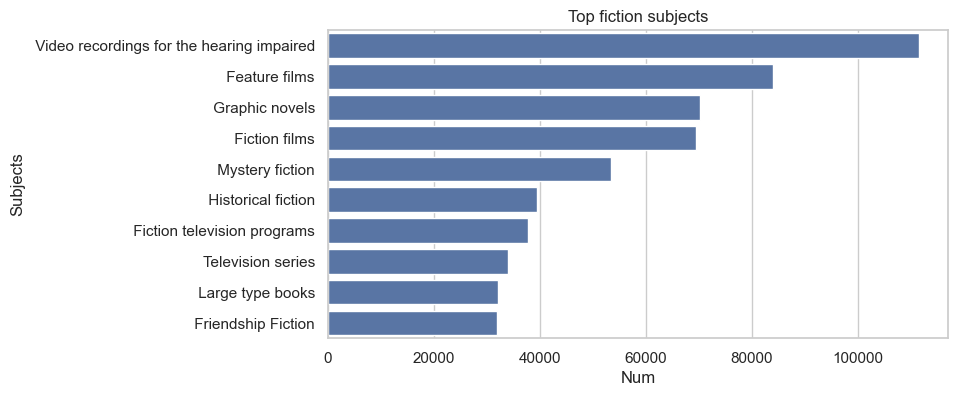

In [49]:
subject_lists = seattle_df['Subjects'].str.split(",").tolist()
flat_list = flat_list = [item for sublist in subject_lists if sublist is not None for item in sublist]

c = Counter(flat_list)
top_10 = c.most_common(10)

top_df = pd.DataFrame(top_10, columns=['Category', 'Count'])
top_df.rename(columns={'index': 'Category'}, inplace=True)

plt.figure(figsize=(8, 4))
sns.barplot(x='Count', y='Category', data=top_df)
plt.title('Top fiction subjects')
plt.xlabel('Num')
plt.ylabel('Subjects')
plt.show()

**Question 3:** Using Vaex, write a function that gets as input a subject name. The function returns the top-20 most _popular_ authors for the input subject (15pt).



In [10]:
def most_popular_authors(df: vaex.DataFrame, subject: str, top: int = 20):
    popular_df = df.dropmissing()

    selected_rows = popular_df[popular_df['Subjects'].apply(lambda x: subject in str(x) if x is not None else False)]['Author'].value_counts().head(top)
    
    return selected_rows

print(most_popular_authors(seattle_df, 'Fiction'))

Patterson, James, 1947-              953
Willems, Mo                          911
Woods, Stuart                        574
Jance, Judith A.                     518
McCall Smith, Alexander, 1948-       503
Connelly, Michael, 1956-             466
O'Connor, Jane                       438
Robb, J. D., 1950-                   436
Evanovich, Janet                     435
Sandford, John, 1944 February 23-    422
Christie, Agatha, 1890-1976          402
Depken, Kristen L.                   399
Rylant, Cynthia                      389
Penny, Louise                        383
Capucilli, Alyssa Satin, 1957-       350
Beaton, M. C.                        343
Perry, Anne                          325
Testa, Maggie                        322
Tillworth, Mary                      315
Leon, Donna                          296
dtype: int64


Using the [The Blog Authorship Corpus](https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus) and Vaex, please answer the following questions:

**Question 4:** Calculate the average and median age of bloggers in each topic by gender(5pt).
Calculate the average and median age of bloggers according to their sign (5pt).
Visualize the age distributions  of bloggers according to their  topic and gender using Seaborn and PlotlyExpress(15pt)

In [39]:
rat_path = kagglehub.dataset_download("rtatman/blog-authorship-corpus")
print("Path to dataset files:", rat_path)

100%|██████████| 290M/290M [00:17<00:00, 17.1MB/s] 

Extracting files...


Path to dataset files: /Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות/datasets/rtatman/blog-authorship-corpus/versions/2


In [23]:
blog_df = next(vaex.from_csv( "/Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות/datasets/rtatman/blog-authorship-corpus/versions/2/blogtext.csv", chunk_size=2_000_000))

In [26]:
topic_gender = blog_df.groupby(['topic', 'gender'], agg={'age': [vaex.agg.mean('age')]})
topic_gender.head(10)

#,topic,gender,age_mean
0,LawEnforcement-Security,female,29.2508
1,LawEnforcement-Security,male,25.3797
2,indUnk,female,24.9647
3,indUnk,male,24.4837
4,Sports-Recreation,female,20.5616
5,Sports-Recreation,male,23.9919
6,Marketing,female,26.0432
7,Marketing,male,29.6977
8,Construction,female,27.5233
9,Construction,male,32.2296


In [ ]:
age_by_sign = blog_df.groupby(['sign'], agg={'age': [vaex.agg.mean('age')]})
age_by_sign.head(10)

#,sign,age_mean
0,Cancer,24.4704
1,Aquarius,23.5372
2,Sagittarius,23.7525
3,Capricorn,24.0984
4,Scorpio,23.6343
5,Leo,23.7792
6,Virgo,23.7806
7,Aries,25.1841
8,Pisces,25.0333
9,Taurus,23.456


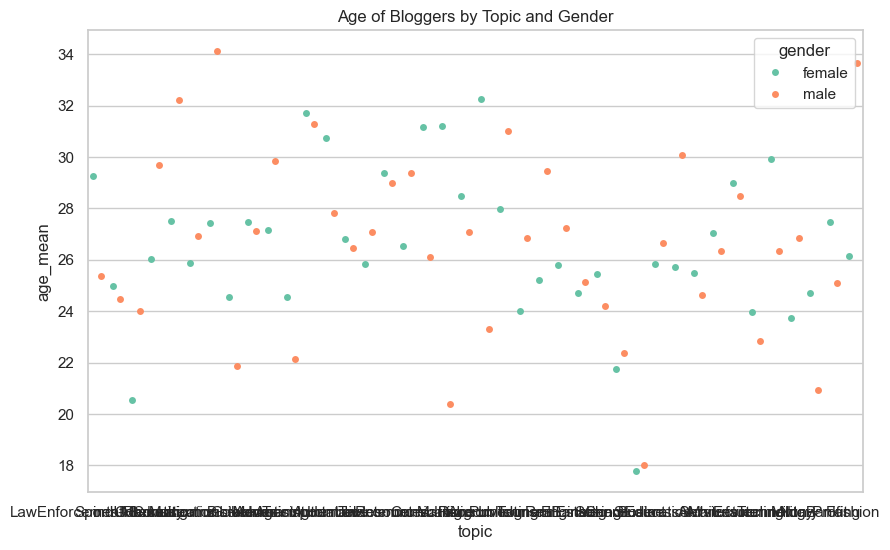

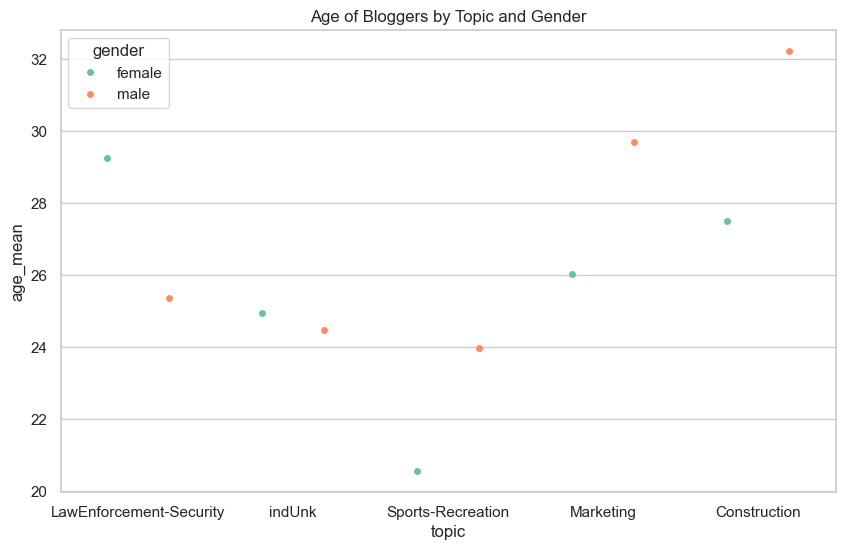

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.stripplot(x='topic', y='age_mean', hue='gender', data=topic_gender.to_pandas_df(), jitter=True, dodge=True, palette='Set2')
plt.title('Age of Bloggers by Topic and Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.stripplot(x='topic', y='age_mean', hue='gender', data=topic_gender.to_pandas_df()[:10], jitter=True, dodge=True, palette='Set2')
plt.title('Age of Bloggers by Topic and Gender')
plt.show()


fig = px.histogram(topic_gender.to_pandas_df(), x='age_mean', color='topic', facet_col='gender', marginal='box', nbins=10)
fig.update_layout(title_text='Age of Bloggers by Topic and Gender')
fig.show()